In [19]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import numpy as np

from torchvision import datasets, transforms

In [20]:
batch_size = 64 # batch size

In [21]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./output', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size
)

In [22]:
# image = next(iter(train_loader))[0][8][0]

# plt.imshow(image, cmap='gray')

In [23]:
class RBM():


  def __init__(self, n_hidden, n_visible, train_loader, learning_rate=0.1, n_iterations=0.01):
    self.W = torch.randn(n_visible, n_hidden)
    self.a = torch.randn(1, n_hidden)  # h0
    self.b = torch.randn(1, n_visible)  # v0
    self.train_loader = train_loader
    self.lr = learning_rate
    self.n_iterations = n_iterations


  def _sample(self, X):
      return X > torch.from_numpy(np.random.random_sample(size=X.shape))

  def reconstruct(self, X):
      positive_hidden = torch.sigmoid(torch.mm(X.view(784, -1).t(), self.W) + self.a)
      hidden_states = self._sample(positive_hidden)
      negative_visible = torch.sigmoid(torch.mm(hidden_states.type(torch.float32), self.W.t()) + self.b)
      return negative_visible


  def fit(self):

    self.training_errors = []
    self.training_reconstructions = []

    for i in range(self.n_iterations):

      if i % 5 == 0:
        print(f"epoch {i} / {self.n_iterations}")

      batch_errors = []

      for data_inputs, data_labels in train_loader:

        batch = data_inputs.view(data_inputs.shape[0], -1)

        # Positive phase
        positive_hidden = torch.sigmoid(torch.mm(batch, self.W) + self.a)
        hidden_states = self._sample(positive_hidden)
        positive_associations = torch.mm(batch.t(), positive_hidden)

        # Negative phase
        negative_visible = torch.sigmoid(torch.mm(hidden_states.type(torch.float32), self.W.t()) + self.b)
        # print(((negative_visible > 0.5).sum().item()/negative_visible.numel())* 100)
        negative_visible = self._sample(negative_visible)
        # print(negative_visible.type(torch.float32))
        negative_hidden = torch.sigmoid(torch.mm(negative_visible.type(torch.float32), self.W) + self.a)
        negative_associations = torch.mm(negative_visible.type(torch.float32).t(), negative_hidden)

        self.W += self.lr * (positive_associations - negative_associations)
        self.a += self.lr * (positive_hidden.sum(axis=0) - negative_hidden.sum(axis=0))
        self.b += self.lr * (batch.sum(axis=0) - negative_visible.sum(axis=0))

        batch_errors.append(torch.mean((batch - negative_visible.type(torch.float32)) ** 2))

      self.training_errors.append(torch.mean(torch.Tensor(batch_errors)))

      # Reconstruct a batch of images from the training set
      idx = np.random.choice(range(784), 64)

      # Initialize an empty tensor to store the combined result
      selected_examples = torch.empty(64, 1, 28, 28)

      # Loop over the indices and combine the tensors
      for i, index in enumerate(idx):
          sample_tensor = train_loader.dataset[index][0]
          selected_examples[i] = sample_tensor

      self.training_reconstructions.append(self.reconstruct(selected_examples))


In [24]:
n_epochs = 50     # number of epochs
lr = 0.05         # learning rate
n_hid = 32       # number of neurons in the hidden layer
n_vis = 784       # number of neurons in the visible layer (=input size)

rbm = RBM(n_hid, n_vis, train_loader, learning_rate=lr, n_iterations=n_epochs)

In [25]:
rbm.fit()

epoch 0 / 50
epoch 5 / 50
epoch 10 / 50
epoch 15 / 50
epoch 20 / 50
epoch 25 / 50
epoch 30 / 50
epoch 35 / 50
epoch 40 / 50
epoch 45 / 50


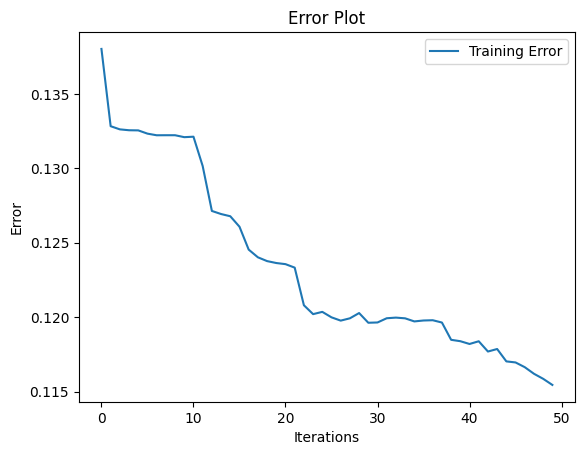

In [26]:
# Training error plot
training, = plt.plot(range(len(rbm.training_errors)), rbm.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

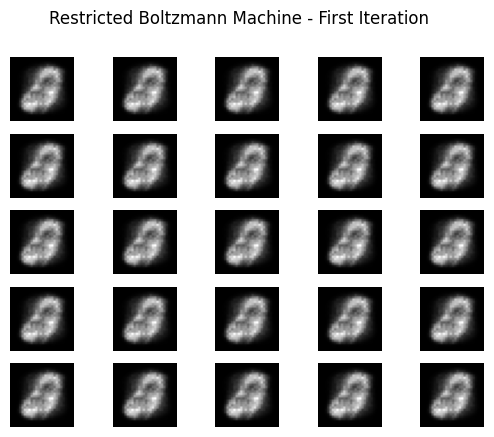

In [27]:
# Get the images that were reconstructed during training
gen_imgs = rbm.training_reconstructions

# Plot the reconstructed images during the first iteration
fig, axs = plt.subplots(5, 5)
plt.suptitle("Restricted Boltzmann Machine - First Iteration")
cnt = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs[0][cnt].reshape((28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
# fig.savefig("rbm_first.png")
plt.show()
plt.close()

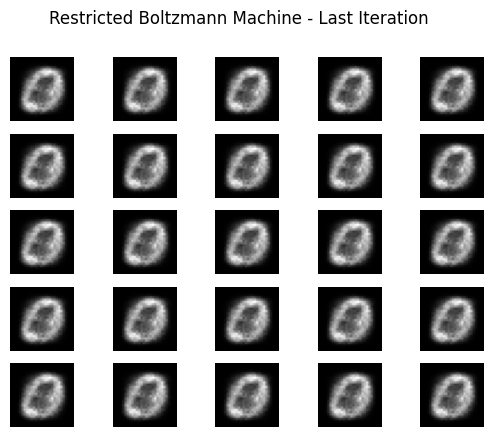

In [28]:
# Plot the images during the last iteration
fig, axs = plt.subplots(5, 5)
plt.suptitle("Restricted Boltzmann Machine - Last Iteration")
cnt = 0
for i in range(5):
  for j in range(5):
    axs[i,j].imshow(gen_imgs[-1][cnt].reshape((28, 28)), cmap='gray')
    axs[i,j].axis('off')
    cnt += 1
# fig.savefig("rbm_last.png")
plt.show()
plt.close()

In [29]:
# see also https://github.com/bacnguyencong/rbm-pytorch/blob/master/Notebook.ipynb

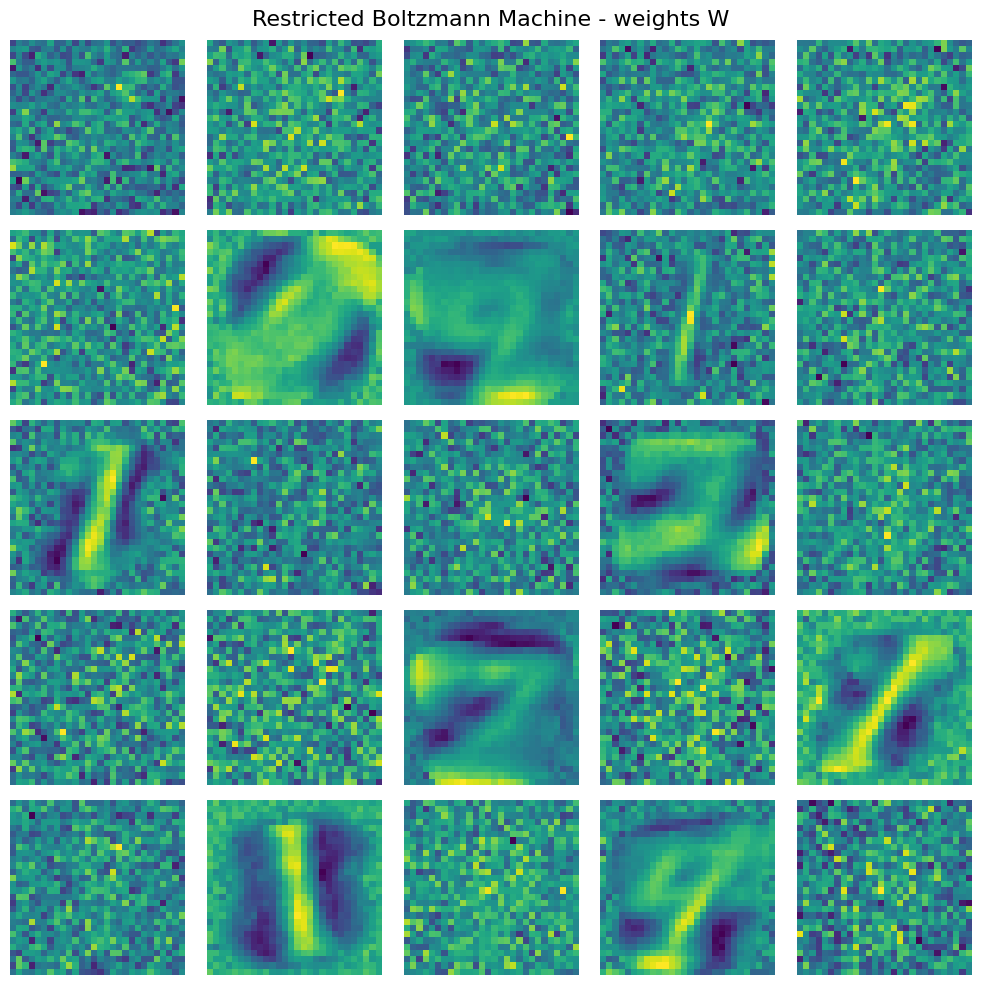

In [30]:
num_fig = 25
num_rows = 5
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
plt.suptitle("Restricted Boltzmann Machine - weights W", fontsize=16)

for i in range(num_fig):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(rbm.W[:, i].reshape((28, 28)))
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()
plt.close()